In [6]:
import os
# change to the root directory of the project
while os.getcwd().split('/')[-1] != 'spectral-properties-of-NN':
    os.chdir('..')
print(os.getcwd())

/home/nadezhda/Desktop/SEMESTER PROJECT/spectral-properties-of-NN


In [7]:
# arguments
import yaml
from omegaconf import OmegaConf
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
# custom
from src.utils.general_utils import lp_distance

### Experiment configuration

In [8]:
EXPERIMENT = "04"
MODEL = "trained"
LANCZOS = "slow"
# get the results directory path
results_dir = f"experiments/{EXPERIMENT}/results/{MODEL}/{LANCZOS}"
print(f"Results directory: {results_dir}")
# load "groundtruth" eigenvalues
# full_eigenvalues = torch.load(os.path.join(results_dir, "HBS_60000/01_run/eigenvalues_iter_100.pt"))

Results directory: experiments/04/results/trained/slow


In [9]:
# get model information from config file
args = OmegaConf.create(yaml.load(open(f"experiments/{EXPERIMENT}/config.yaml"), Loader=yaml.SafeLoader))
plot_title = f"{MODEL.capitalize()} - {args.model_name} - {args.dataset}"
print(f"Plot title: {plot_title}")

Plot title: Trained - ConvNetwork - CIFAR10


### Extract configurations and eigenvalues

In [10]:
# create lists to store configurations and data
configs = []
all_eigenvalues = []

for batch_dir in sorted(os.listdir(results_dir), key=lambda x: int(x.split('_')[1])):
    if batch_dir.startswith('HBS_'):
        batch_size = int(batch_dir.split('_')[1])
        batch_path = os.path.join(results_dir, batch_dir)                
        for run_dir in sorted(os.listdir(batch_path)):
            if run_dir.endswith('_run'):
                run_path = os.path.join(batch_path, run_dir)
                run_num = int(run_dir.split('_')[0])
                for file in sorted(os.listdir(run_path)):
                    if file.startswith('eigenvalues_iter_100'):
                        iter_num = int(file.split('_')[-1].split('.')[0])
                        # load data
                        gradient_norm = torch.load(os.path.join(run_path, f'gradient_norm_{iter_num}.npy'))
                        eigenvalues = torch.load(os.path.join(run_path, f'eigenvalues_iter_{iter_num}.pt'))
                        weights = torch.load(os.path.join(run_path, f'weights_iter_{iter_num}.pt'))
                        # store configuration and data
                        configs.append({
                            'lanczos': LANCZOS,
                            'batch_size': batch_size,
                            'run_num': run_num,
                            'iter_num': iter_num,
                            'gradient_norm': gradient_norm,
                            # 'L1 distance': lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 1).item(),
                            # 'L2 distance': lp_distance(torch.FloatTensor(eigenvalues), torch.FloatTensor(full_eigenvalues), 2).item()
                        })
                        all_eigenvalues.append(eigenvalues)

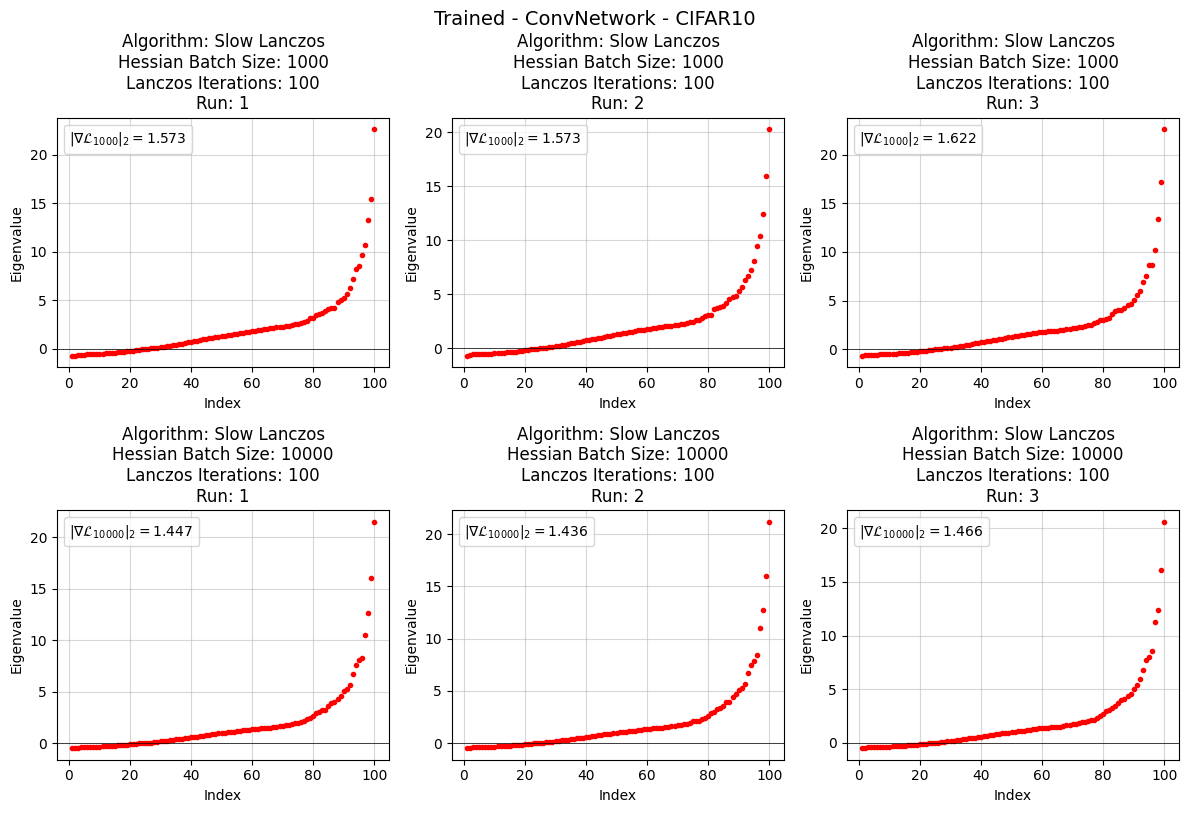

In [11]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    sorted_eigenvalues = np.sort(eigenvalues)
    x_indices = np.arange(1, len(sorted_eigenvalues) + 1)
    plt.plot(x_indices, sorted_eigenvalues, marker="o", linestyle="", color="red", markersize=3)
    plt.axhline(y=0, color='black', linestyle='-', linewidth=0.5)  # Add horizontal line at y=0
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    legend = [
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {config['batch_size'] }}} \|_2 = {np.round(config['gradient_norm'], 3)}$"), 
        ]
    plt.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    plt.grid(True, alpha=0.5)
    plt.xlabel('Index')
    plt.ylabel('Eigenvalue')
plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.savefig(f"results/plots/batch size effect/{plot_title}.png")
plt.show()

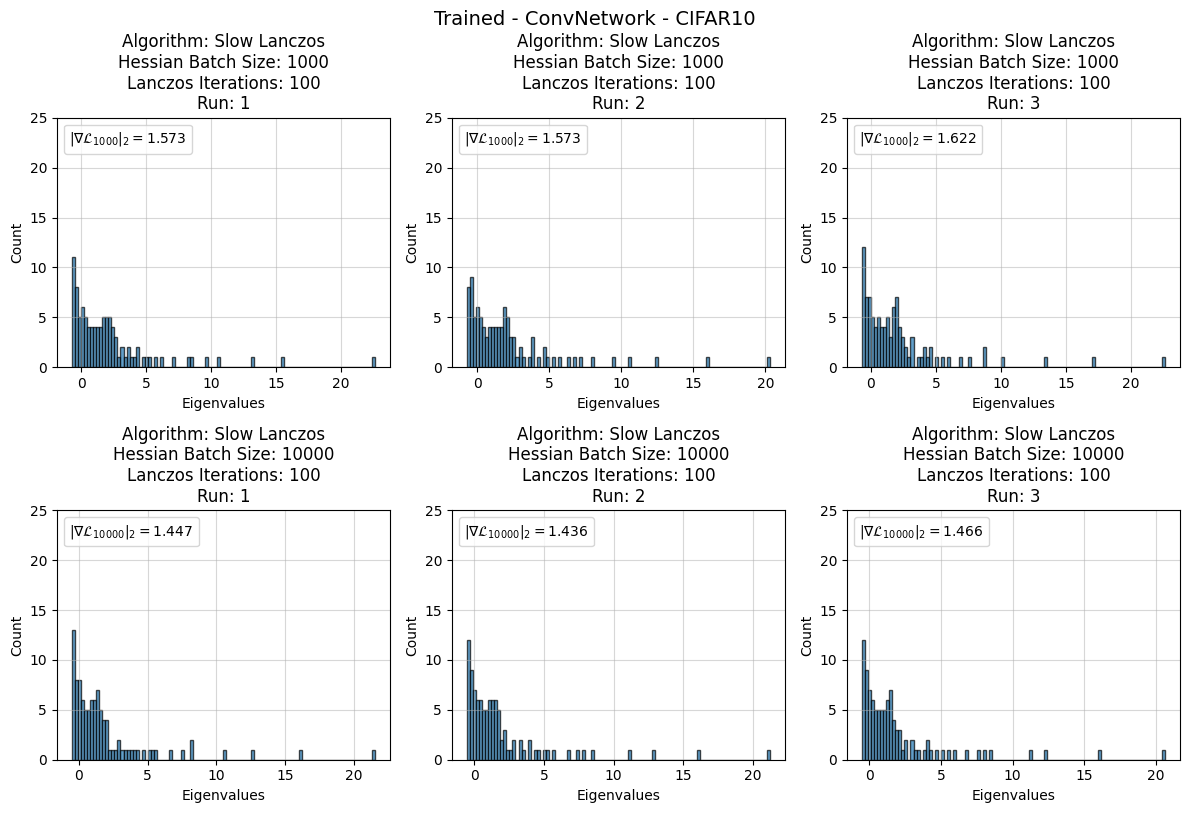

In [12]:
# create subplot grid
n_plots = len(configs)
n_cols = 3  
n_rows = (n_plots + n_cols - 1) // n_cols
# create figure
plt.figure(figsize=(4*n_cols, 4*n_rows))
# create subplots
for idx, (config, eigenvalues) in enumerate(zip(configs, all_eigenvalues)):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.hist(eigenvalues, bins=100, alpha=0.7, edgecolor='black')
    plt.title(f"Algorithm: {config['lanczos'].capitalize()} Lanczos\nHessian Batch Size: {config['batch_size']}\nLanczos Iterations: {config['iter_num']}\nRun: {config['run_num']}")
    legend = [
        Patch(facecolor='white', edgecolor='white', label=fr"$\| \nabla \mathcal{{L}}_{{ {config['batch_size'] }}} \|_2 = {np.round(config['gradient_norm'], 3)}$")
        ]
    plt.legend(handles=legend, loc='upper left', handlelength=0, handletextpad=0)
    plt.grid(True, alpha=0.5)
    plt.xlabel("Eigenvalues")
    plt.ylabel("Count")
    plt.ylim(0, 25)

plt.tight_layout()
plt.suptitle(plot_title, y=1.01, fontsize=14)
plt.show()